In [1]:
import numpy as np
import scipy.stats as stats

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import seaborn as sns

import plotly
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
# pio.renderers.default='notebook'

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import acf
from sklearn.linear_model import LinearRegression
import regex as re

In [2]:
df = pd.read_csv('all_data.csv')
df.head()

,Unnamed: 0,text,Label_by_zihan,Label_by_ben,Label_by_nicole,average,label,Qwen 1.5 Chat (0.5B),Qwen 1.5 Chat (1.8B),Qwen 1.5 Chat (4B),Qwen 1.5 Chat (7B),Qwen 1.5 Chat (14B),Qwen 1.5 Chat (72B),LLaMA-2 Chat (70B),GPT-4o,GPT-3.5 Turbo,GPT-4 Turbo,GPT-4o W/O Reasoning,Sentiment Roberta,Custmized Bert
0,0,what do these '1/2 naked pics' have to do with...,3.0,3.0,4.0,3.333333,5,1.0,3.0,1.0,6.0,3.0,3.0,3.0,3.0,3.0,5.0,2.0,3.000812,3.385936
1,1,OH: “I had a blue penis while I was this” [pla...,5.0,5.0,6.0,5.333333,5,7.0,7.0,0.0,0.0,3.0,3.0,6.0,5.0,5.0,6.0,1.0,5.122762,6.015794
2,2,"That's coming, but I think the victims are goi...",5.0,6.0,5.0,5.333333,5,7.0,5.0,2.0,5.0,3.0,4.0,3.0,2.0,2.0,3.0,3.0,4.173433,4.166149
3,3,I think I may be finally in with the in crowd ...,7.0,9.0,7.0,7.666667,10,7.0,7.0,1.0,8.0,6.0,6.0,8.0,8.0,8.0,8.0,8.0,6.907494,7.103713
4,4,"Wow,first Hugo Chavez and now Fidel Castro. Da...",4.0,2.0,3.0,3.000000,0,7.0,7.0,2.0,2.0,3.0,4.0,3.0,3.0,2.0,2.0,2.0,4.960894,3.268210


In [15]:
qwen_all = df.columns[7:13]
data = []
for model in qwen_all:
    params = re.search(r'(\d+(\.\d+)?)([B])', model)
    if params:
        number, _, unit = params.groups()
        number = np.log(float(number) * (1e9))
        diffs = (df[model] - df['average']).abs()
        data.append((model, number, diffs.mean()))

In [16]:
model_params = pd.DataFrame(data, columns=['Model', '# Parameters', 'Average Diffs'])
X = model_params['# Parameters'].values.reshape(-1, 1)
y = model_params['Average Diffs'].values

model = LinearRegression()
model.fit(X, y)
slope = model.coef_[0]
intercept = model.intercept_
r_squared = model.score(X, y)

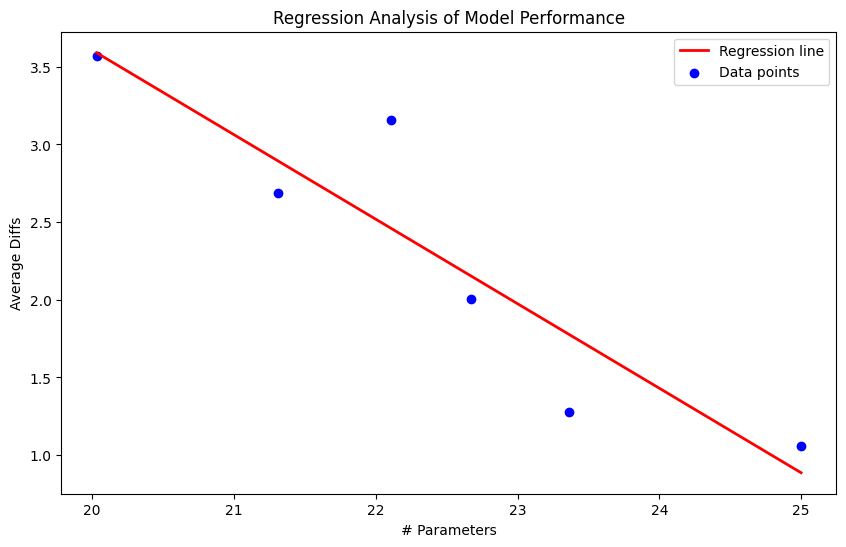

In [17]:
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', label='Data points')
plt.plot(X, model.predict(X), color='red', linewidth=2, label='Regression line')
plt.xlabel('# Parameters')
plt.ylabel('Average Diffs')
plt.title('Regression Analysis of Model Performance')
plt.legend()
plt.show()

# One Sample KS Test

<AxesSubplot:xlabel='average', ylabel='Proportion'>

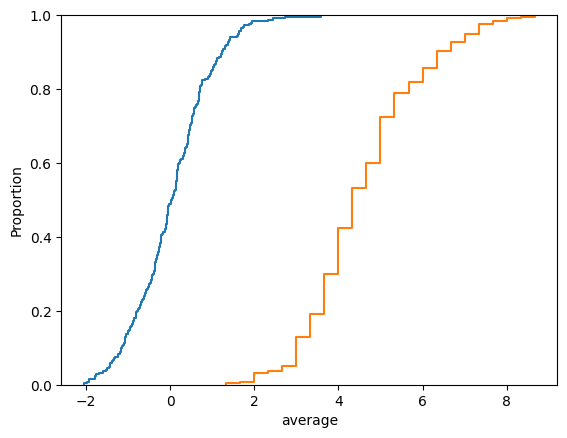

In [67]:
u = np.random.normal(loc=0, scale=1, size=df.shape[0])
w = df['average']
sns.ecdfplot(u)
sns.ecdfplot(w)

In [68]:
KS_result = stats.kstest(u, w)
KS_result.pvalue

3.607488139326509e-136

Using standard normal distribution centered at 0 with standard deviation of 1, we can see that our rated scores do not even fall close to this distribution. The p-value for this ks-test is well below the significance value of 0.05 and thus we suggest that our averages are clearly not drawn from the standard normal distribution

We can attempt to fit the best normal distribution we can on our average data and see if our averages follow the best normal distribution we can fit.

<AxesSubplot:xlabel='average', ylabel='Proportion'>

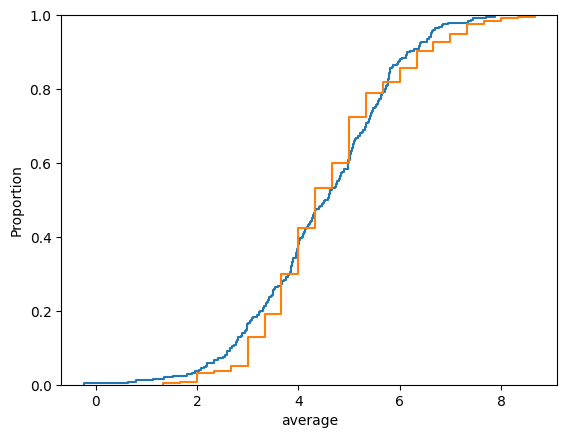

In [69]:
mu, std = stats.norm.fit(df['average'])
u_new = np.random.normal(loc=mu, scale=std, size=df.shape[0])
sns.ecdfplot(u_new)
sns.ecdfplot(w)

In [74]:
KS_result_new = stats.kstest(u_new, w)
KS_result_new.pvalue

0.06913382718790878

In [71]:
mu, std

(4.5919999999800005, 1.3362394994649525)

After fitting the best normal distribution on our data, we can see that our p-value is 0.06 which is higher than the significance value so we reject the alternative in favor of the null suggesting that our data is sampled from a normal distribution centered at 4.59 with a standard deviation of 1.34

# Two Sample KS-Test

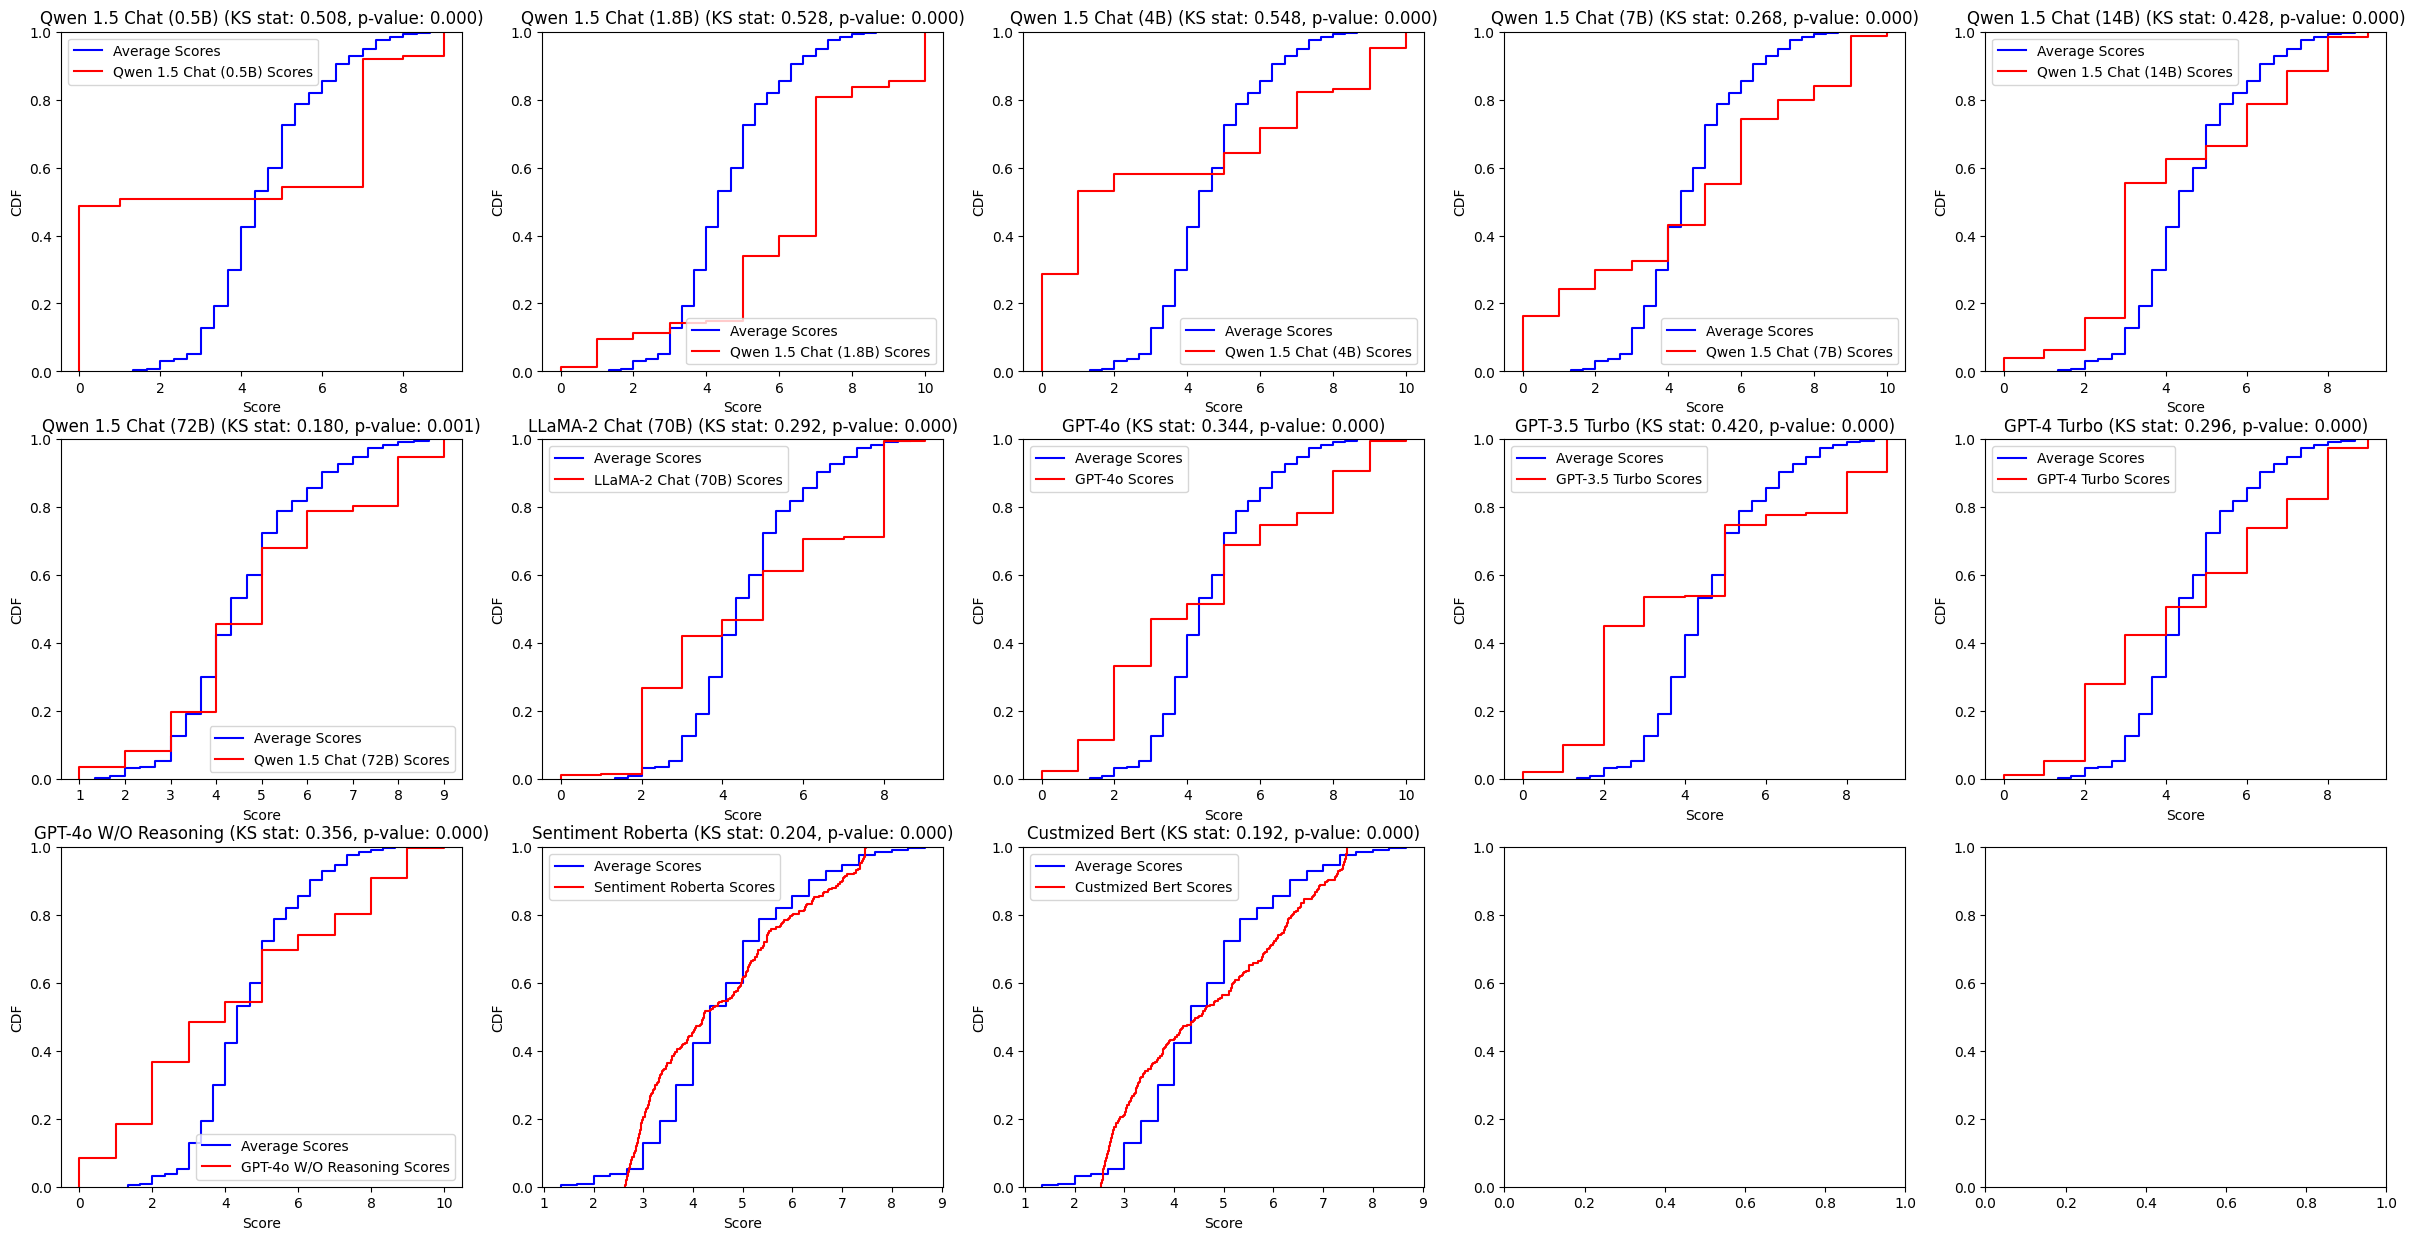

In [10]:
average_human_scores = df['average']
model_columns = df.columns[7:]
num_cols = 5
num_rows = 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(30, 5 * num_rows))
axes = axes.flatten()

ks_test_results = {}

for idx, model in enumerate(model_columns):
    model_scores = df[model]

    ks_statistic, p_value = stats.kstest(model_scores, average_human_scores)

    sns.ecdfplot(average_human_scores, ax=axes[idx], label='Average Scores', color='blue')
    sns.ecdfplot(model_scores, ax=axes[idx], label=f'{model} Scores', color='red')

    ks_test_results[model] = {
        'KS Statistic': ks_statistic,
        'P-Value': p_value
    }
    
    axes[idx].set_title(f'{model} (KS stat: {ks_statistic:.3f}, p-value: {p_value:.3f})')
    axes[idx].set_xlabel('Score')
    axes[idx].set_ylabel('CDF')
    axes[idx].legend()

    

In [11]:
ks_test_results

{'Qwen 1.5 Chat (0.5B)': {'KS Statistic': 0.508,
  'P-Value': 9.925049232409705e-30},
 'Qwen 1.5 Chat (1.8B)': {'KS Statistic': 0.528,
  'P-Value': 3.247941845516451e-32},
 'Qwen 1.5 Chat (4B)': {'KS Statistic': 0.548,
  'P-Value': 8.062092877173741e-35},
 'Qwen 1.5 Chat (7B)': {'KS Statistic': 0.268,
  'P-Value': 2.647653916448716e-08},
 'Qwen 1.5 Chat (14B)': {'KS Statistic': 0.428,
  'P-Value': 6.299423012828687e-21},
 'Qwen 1.5 Chat (72B)': {'KS Statistic': 0.18,
  'P-Value': 0.0005903920176393534},
 'LLaMA-2 Chat (70B)': {'KS Statistic': 0.292,
  'P-Value': 8.446496367049339e-10},
 'GPT-4o': {'KS Statistic': 0.344, 'P-Value': 1.6366493208588368e-13},
 'GPT-3.5 Turbo': {'KS Statistic': 0.42, 'P-Value': 3.834321214302795e-20},
 'GPT-4 Turbo': {'KS Statistic': 0.296, 'P-Value': 4.614289681999176e-10},
 'GPT-4o W/O Reasoning': {'KS Statistic': 0.356,
  'P-Value': 1.8355059736733046e-14},
 'Sentiment Roberta': {'KS Statistic': 0.204,
  'P-Value': 5.754062871035665e-05},
 'Custmized Ber

In [12]:
best_model = max(ks_test_results, key=lambda x: ks_test_results[x]["P-Value"])
print(f'{best_model}\'s distribution was most closely to ours with {ks_test_results[best_model]}')

Qwen 1.5 Chat (72B)'s distribution was most closely to ours with {'KS Statistic': 0.18, 'P-Value': 0.0005903920176393534}


In [14]:
resoning_scores = df['GPT-4o']
without_reasoning_scores = df['GPT-4o W/O Reasoning']
t_statistic, p_value = stats.ttest_ind(resoning_scores, without_reasoning_scores)
print(f'Paired sample t-test p-value: {p_value}')
print(f'Paired sample t-test t-statistic: {t_statistic}')

Paired sample t-test p-value: 0.3631155932061403
Paired sample t-test t-statistic: 0.9102793071287404


In [18]:
mae_results = {}
model_columns = df.columns[7:]

for model in model_columns:
    mae = (df[model] - df['average']).abs().mean()
    mae_results[model] = mae

mae_results
dict(sorted(mae_results.items(), key=lambda item: item[1]))

{'Sentiment Roberta': 0.6257107239879999,
 'Custmized Bert': 0.8029645272199999,
 'Qwen 1.5 Chat (72B)': 1.0586666666359998,
 'GPT-4 Turbo': 1.239999999996,
 'Qwen 1.5 Chat (14B)': 1.280000000004,
 'LLaMA-2 Chat (70B)': 1.369333333332,
 'GPT-4o': 1.4426666666680001,
 'GPT-3.5 Turbo': 1.5693333333400001,
 'GPT-4o W/O Reasoning': 1.6266666666679999,
 'Qwen 1.5 Chat (7B)': 2.006666666652,
 'Qwen 1.5 Chat (1.8B)': 2.687999999988,
 'Qwen 1.5 Chat (4B)': 3.1599999999960002,
 'Qwen 1.5 Chat (0.5B)': 3.5679999999880003}